每小时出租车司机数量统计

   Unnamed: 0  vehicle_num                 date   longitude  latitude  status
0        2114        10004  2007-02-20 00:08:45  121.414583     31.16       1
1        2115        10004  2007-02-20 00:11:55  121.414583     31.16       1
2        2116        10004  2007-02-20 00:18:13  121.414583     31.16       1
3        2117        10004  2007-02-20 00:24:31  121.414583     31.16       1
4        2118        10004  2007-02-20 00:27:40  121.414583     31.16       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4429131 entries, 0 to 4429130
Data columns (total 5 columns):
vehicle_num    int64
date           object
longitude      float64
latitude       float64
status         int64
dtypes: float64(2), int64(2), object(1)
memory usage: 169.0+ MB


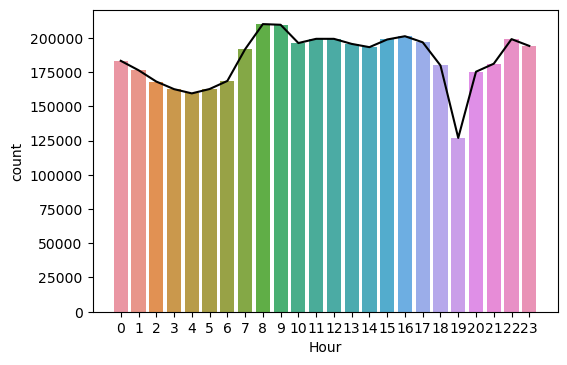

In [1]:
import os
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
%matplotlib inline

sh_od = pd.read_csv('./data-sample/sh_od.csv')
print (sh_od.head())
sh_od = sh_od[['vehicle_num','date','longitude','latitude','status']]
sh_od.info()

sh_od['Hour'] = sh_od['date'].apply(lambda x: int((x.split(' ')[1]).split(':')[0]))
hourcount = sh_od.groupby('Hour')['vehicle_num'].count().rename('count_each_hour').reset_index()
###################################################################################
# ?sb.countplot
plt.figure(dpi=100)
sb.countplot(x='Hour',data=sh_od)
plt.plot(hourcount['Hour'],hourcount['count_each_hour'],color='black')
# plt.ylim([50000,75000])
plt.savefig('images/hour_count.png',dpi=150)
plt.show()

画散点热力图,按区域划分

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

sh_od = pd.read_csv('./data-sample/sh_od.csv')
print (sh_od.head())
sh_od = sh_od[['vehicle_num','date','longitude','latitude','status']]
sh_od.info()

   Unnamed: 0  vehicle_num                 date   longitude  latitude  status
0        2114        10004  2007-02-20 00:08:45  121.414583     31.16       1
1        2115        10004  2007-02-20 00:11:55  121.414583     31.16       1
2        2116        10004  2007-02-20 00:18:13  121.414583     31.16       1
3        2117        10004  2007-02-20 00:24:31  121.414583     31.16       1
4        2118        10004  2007-02-20 00:27:40  121.414583     31.16       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4429131 entries, 0 to 4429130
Data columns (total 5 columns):
vehicle_num    int64
date           object
longitude      float64
latitude       float64
status         int64
dtypes: float64(2), int64(2), object(1)
memory usage: 169.0+ MB


空间连接，将不在区划内的数据去掉

In [3]:
# 取小数点后三位再groupyby，相当于选中了相应的区域
sh_od = sh_od[['longitude','latitude']]
sh_od = sh_od.round(3)

# aggregate
sh_od['count'] = 1
sh_od = sh_od.groupby(['longitude','latitude'])['count'].count().reset_index()
sh_od = sh_od.sort_values(by='count')

In [5]:
sh_xzgh = gpd.GeoDataFrame.from_file('./shapefile/shanghai_shp/区县界_area.shp')
# 空间连接，筛选掉问题数据
sh_od['geometry'] = sh_od.apply(lambda x: Point(x['longitude'],x['latitude']),axis=1)
sh_od_gpd = gpd.GeoDataFrame(sh_od)
print (sh_od_gpd.shape)
sh_od_gpd = sh_od_gpd[sh_od_gpd.intersects(sh_xzgh.unary_union)]
print (sh_od_gpd.shape)

(94318, 4)
(88654, 4)


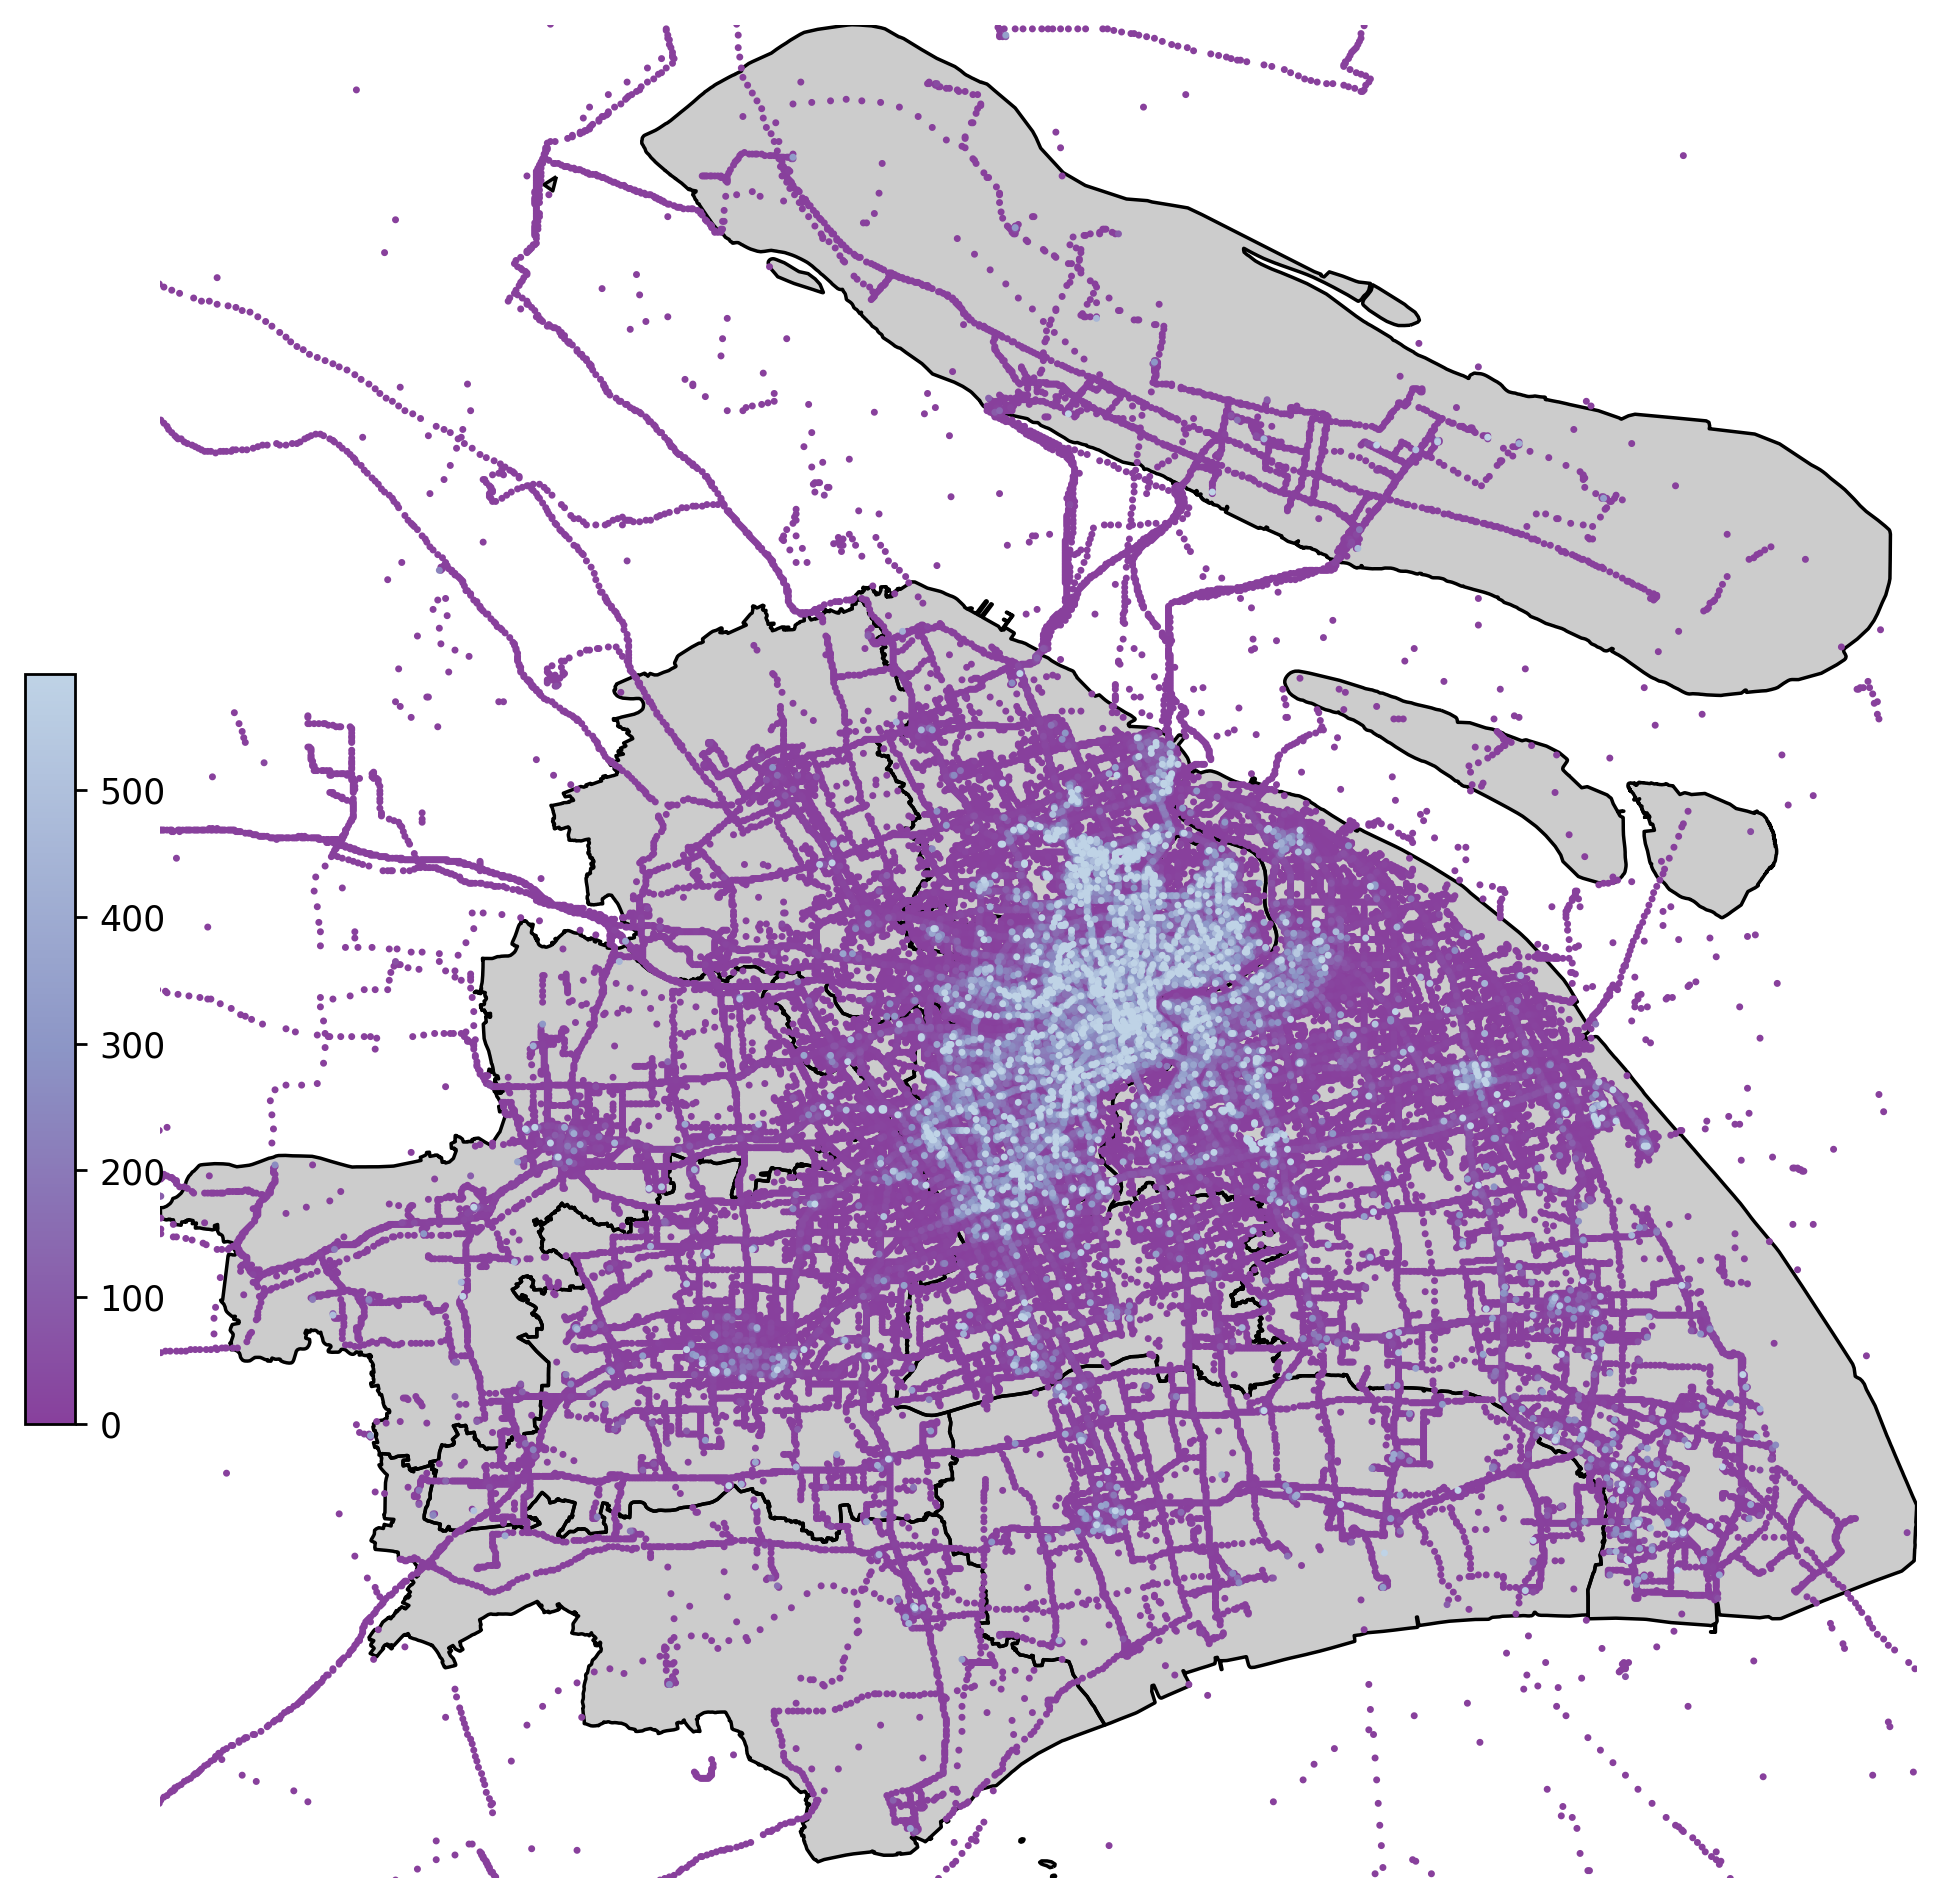

In [6]:
bounds = [120.8517, 121.9741, 30.6823, 31.8666]

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
fig     = plt.figure(1,(10,10),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#adjust the layout of the figure

sh_xzgh.plot(ax=ax,facecolor=(0,0,0,0.2),edgecolor=(0,0,0,1))
#colorbar
pallete_name = "BuPu"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
vmax = sh_od['count'].quantile(0.99)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)


#plot scatters
plt.scatter(sh_od['longitude'],sh_od['latitude'],s = 1,alpha = 1,c = sh_od['count'],cmap = cmap,norm=norm)
plt.axis('off')
plt.xlim(bounds[0],bounds[1])
plt.ylim(bounds[2],bounds[3])

#fake colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)
plt.savefig('./images/region_distribution',dpi=250)
plt.show()
###################################################################################